# Active Learning Practical

Ternon Louis

Sevestre Pierre

Pietrantoni Maxime


Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that you will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)


In [3]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:])-1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

You can here define your model that will be used for the Active learning process:

In [68]:
class Model(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(13824, 2048),
            nn.ReLU(),
            nn.Linear(2048,100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0],1,28,28)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        output = self.classifier(x)
        
        return output
    
    

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [6]:
# number of times the expert will be called to label a batch of examples
num_active_runs = 40

# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
num_iter = 100
batch_size = 200

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

## Local methods



 Uncertainty Sampling 

We pick the samples whose highest prediction probability are the lowest.
 
 $$argmin_i sup_c \hat{y_i^c}$$
 
 Margin Sampling
 
We pick the samples whose whose difference between the two highest probabilities are the lowest.
     $$argmin_i \hat{y_i^{c1}}-\hat{y_i^{c2}}$$
with $c1 = argmax_c\hat{y_i^c}$ and $c2 = argmax_{c\neq c_1}\hat{y_i^c}$ 

Entropy Sampling

We pick the samples with the highest entropy over all of the 10 predictions probabilities.
$$argmax_i H(\hat{y_i^c})$$
with $H(\hat{y_i^c}) = -\sum_c \hat{y_i^c}log(\hat{y_i^c})$

In [83]:
def random_strategy(model, dataset,n_new):
    # label 100 new examples at random
    N = len(dataset)
    return torch.randint(0, N, (n_new,))

def uncertainty_sampling(model, dataset,n_new):
    # implement your strategies as new functions here
    loader = DataLoader(dataset, batch_size=50, shuffle=False)
    a = torch.zeros((0,10))
    with torch.no_grad():
        for (data, targets) in loader:
            data = data.reshape(data.shape[0],1,28,28)
            predictions = model(data)
            a = torch.cat((a,predictions),dim=0)
        #print(prediction.shape)
    proba_max,_ = a.max(1)
    s,new_indices = proba_max.reshape(proba_max.shape,1).sort()
    #new_indices = new_indices.reshape(new_indices.shape,1)[:100]

    return new_indices[:n_new]

def margin_sampling(model, dataset,n_new):
    loader = DataLoader(dataset, batch_size=50, shuffle=False)
    a = torch.zeros((0,10))
    with torch.no_grad():
        for (data, targets) in loader:
            data = data.reshape(data.shape[0],1,28,28)
            predictions = model(data)
            a = torch.cat((a,predictions),dim=0)
        #print(prediction.shape)
    top2,a = a.topk(2,dim=1)
    margin = top2[:,0]-top2[:,1]
    s,margin_indices = margin.sort()

    return margin_indices[:n_new]

def entropy(model, dataset,n_new):
    
    loader = DataLoader(dataset, batch_size=50, shuffle=False)
    a = torch.zeros((0,10))
    with torch.no_grad():
        for (data, targets) in loader:
            data = data.reshape(data.shape[0],1,28,28)
            predictions = model(data)
            a = torch.cat((a,predictions),dim=0)
    
    a = a.numpy()
    am = a.min(1).reshape(a.shape[0],1)
    amm = a.max(1).reshape(a.shape[0],1)
    a = np.divide(a-am,np.repeat(amm-am,a.shape[1],axis=1))
    a = torch.tensor(a)
    
    entropy = torch.tensor([-sum([p*torch.log(p) for p in line if p>0]) for line in a])
    s,entropy_indices = entropy.sort()

    return entropy_indices[-n_new:]

## explanations below
def committee_selection(models, dataset,n_new):
    ## odels : dictionnary of trained models with the same parameters.
    probas = torch.zeros((len(dataset),10,len(models)))
    for n_mod,model in models.items():
        loader = DataLoader(dataset, batch_size=50, shuffle=False)
        a = torch.zeros((0,10))
        with torch.no_grad():
            for (data, targets) in loader:
                data = data.reshape(data.shape[0],1,28,28)
                predictions = model(data)
                a = torch.cat((a,predictions),dim=0)        
        probas[:,:,n_mod] = a
        
        
    probas = probas.numpy()
    var_probas = np.var(probas,axis=2)
    p = np.mean(var_probas,axis=1)
    p = torch.tensor(p)
    s,indices = p.sort()

    return indices[-n_new:]




This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [9]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses

def active_training_adaptative_model(strategy, dataset=None, initial_labeling=20,added_labeling=25):
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                model.zero_grad()
                data = data.reshape(data.shape[0],1,28,28)
                prediction = model(data)   
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                #data = data.view(-1,28*28)
                data = data.reshape(data.shape[0],1,28,28)

                prediction = model(data)
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)
    

    N_neurons = 20
    output_dim = 10
    N_fc_layers = 2
    N_filters = 3
    kernel_size = 10
    stride = 2
    
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        
        # create a new model to train on this dataset
        if i%5==0:
            N_neurons +=1
        if i%10==0:
            N_filters += 1
            
        input_dim = ((28-kernel_size)/stride+1)*((28-kernel_size)/stride+1)*N_filters
        dims = np.concatenate(([input_dim],[N_neurons]*(N_fc_layers-1),[output_dim]))
        dims = dims.astype('int')
        arch = [nn.Sequential(nn.Conv2d(1,N_filters,kernel_size,stride)),nn.Sequential(nn.Flatten())]
        arch += [nn.Sequential(nn.Linear(input_dim,output_dim)) if output_dim!=10 else nn.Sequential(nn.Linear(input_dim,output_dim)) for input_dim,output_dim in zip(dims[:-1],dims[1:])]
        model = nn.Sequential(*arch)

        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, optimizer, loader, 50)
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: {} -- {}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = strategy(model, dataset,added_labeling)
            call_expert(dataset, to_label)
    
    return performances


def active_training(strategy, dataset=None, initial_labeling=20,added_labeling=25):
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                model.zero_grad()
                data = data.reshape(data.shape[0],1,28,28)
                prediction = model(data)   
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                #data = data.view(-1,28*28)
                data = data.reshape(data.shape[0],1,28,28)

                prediction = model(data)
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)

    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        
        # create a new model to train on this dataset
        model = Model()

        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, optimizer, loader, 50)
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: {} -- {}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = strategy(model, dataset,added_labeling)
            call_expert(dataset, to_label)
    
    return performances

The following cells contain code that you can use to compare your different strategies. Fill the `strategies` list with the name of the functions implementing your strategies, and run the cell to compare them.

## Adaptative Basic Networks

We firstly use a very basic network with one convolutional layer and one fully connected layer. As the number of samples increases we complexify the aforementioned network by adding neurons or filters in our two layers. We do that instead of increase the number of layers because it has be shown that one should rather a large layer than multiple thin layers. We use high kernel size and stride to restrain the number of parameters.

The initial number of samples is set to 50. Under that we may be too vulnerable to the variability in the information contained in the sampled training set.

The optimizer is Adam with a learning rate of 0.001. From our experience it seems that a 'low' learning rate is better suited to these low sample problems.

In [11]:
num_active_runs = 100
num_iter = 100
batch_size = 150

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

# a list of strategies you want to compare
local_strategies = [random_strategy,uncertainty_sampling,margin_sampling,entropy]
# number of examples to label randomly at the start
initial_labeling = 50
added_labeling = 5
performances = []
for strat in local_strategies:
    print("Training with strategy: {}".format(strat.__name__))
    perf = active_training_adaptative_model(strat, initial_labeling=initial_labeling,added_labeling=added_labeling)
    performances.append((strat.__name__, perf))
print("done")

Training with strategy: random_strategy
With 50 examples, valid perf is: 1.2144400310516357 -- 66.15999603271484%
With 55 examples, valid perf is: 1.2002020007371903 -- 67.37999725341797%
With 60 examples, valid perf is: 1.0538327211141587 -- 68.05999755859375%
With 65 examples, valid perf is: 1.0364542376995087 -- 70.27999877929688%
With 70 examples, valid perf is: 1.009736755490303 -- 67.33999633789062%
With 75 examples, valid perf is: 0.8736624902486801 -- 73.65999603271484%
With 80 examples, valid perf is: 0.816572493314743 -- 73.81999969482422%
With 85 examples, valid perf is: 0.8727043771743774 -- 73.54000091552734%
With 90 examples, valid perf is: 0.8365848046541214 -- 73.6199951171875%
With 95 examples, valid perf is: 0.7897229731082916 -- 74.94000244140625%
With 100 examples, valid perf is: 0.7804185944795609 -- 75.41999816894531%
With 105 examples, valid perf is: 0.6628112107515335 -- 79.79999542236328%
With 110 examples, valid perf is: 0.7153054228425026 -- 77.63999938964844

With 95 examples, valid perf is: 0.9953261411190033 -- 68.5199966430664%
With 100 examples, valid perf is: 1.202827706336975 -- 66.04000091552734%
With 105 examples, valid perf is: 1.0116118669509888 -- 70.8800048828125%
With 110 examples, valid perf is: 1.0323840481042863 -- 67.47999572753906%
With 115 examples, valid perf is: 0.909377914071083 -- 69.4000015258789%
With 120 examples, valid perf is: 1.1270017582178116 -- 65.97999572753906%
With 125 examples, valid perf is: 0.9337240213155746 -- 69.63999938964844%
With 130 examples, valid perf is: 0.9301027423143386 -- 70.16000366210938%
With 135 examples, valid perf is: 0.8145282298326493 -- 73.22000122070312%
With 140 examples, valid perf is: 1.070849558711052 -- 67.77999877929688%
With 144 examples, valid perf is: 0.9809091013669967 -- 68.54000091552734%
With 149 examples, valid perf is: 0.8484245550632477 -- 73.0199966430664%
With 153 examples, valid perf is: 1.0921071749925613 -- 65.9000015258789%
With 158 examples, valid perf is: 

With 145 examples, valid perf is: 0.5822588139772416 -- 82.80000305175781%
With 150 examples, valid perf is: 0.5521752315759659 -- 84.55999755859375%
With 155 examples, valid perf is: 0.6056955221295357 -- 82.23999786376953%
With 160 examples, valid perf is: 0.5659032955765724 -- 83.16000366210938%
With 165 examples, valid perf is: 0.510390871167183 -- 85.0199966430664%
With 170 examples, valid perf is: 0.5450294792652131 -- 84.75999450683594%
With 175 examples, valid perf is: 0.5759969532489777 -- 84.97999572753906%
With 180 examples, valid perf is: 0.5536993479728699 -- 85.6199951171875%
With 185 examples, valid perf is: 0.5528526028990746 -- 85.1199951171875%
With 190 examples, valid perf is: 0.5481804957985879 -- 85.79999542236328%
With 195 examples, valid perf is: 0.539087218940258 -- 85.9000015258789%
With 200 examples, valid perf is: 0.5905273455381393 -- 85.69999694824219%
With 205 examples, valid perf is: 0.5568304291367531 -- 86.13999938964844%
With 210 examples, valid perf i

With 189 examples, valid perf is: 0.6024107903242111 -- 82.45999908447266%
With 194 examples, valid perf is: 0.5557222545146943 -- 83.80000305175781%
With 199 examples, valid perf is: 0.6536870101094245 -- 82.27999877929688%
With 204 examples, valid perf is: 0.6306896111369134 -- 83.20000457763672%
With 209 examples, valid perf is: 0.6391591882705688 -- 83.08000183105469%
With 214 examples, valid perf is: 0.6589723634719848 -- 81.4800033569336%
With 219 examples, valid perf is: 0.7105776113271713 -- 81.5%
With 224 examples, valid perf is: 0.6587635353207588 -- 82.95999908447266%
With 229 examples, valid perf is: 0.6622701787948608 -- 82.22000122070312%
With 234 examples, valid perf is: 0.6856776309013367 -- 82.34000396728516%
With 239 examples, valid perf is: 0.6227843824028969 -- 83.20000457763672%
With 244 examples, valid perf is: 0.6435560759902 -- 82.92000579833984%
With 249 examples, valid perf is: 0.6369477355480194 -- 83.45999908447266%
With 254 examples, valid perf is: 0.681386

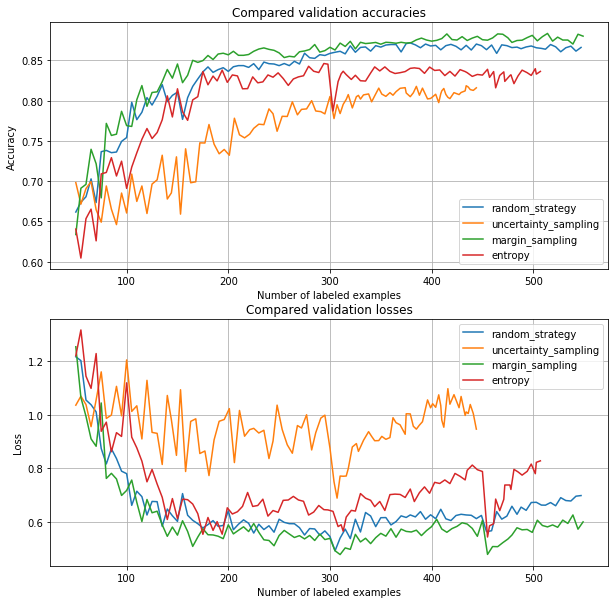

In [16]:
fig,ax = plt.subplots(2,1,figsize=(10,10))

for (name, perf) in performances:
    ax[0].plot(perf[:,0], perf[:,1], label=name)
ax[0].legend(loc='lower right')
ax[0].grid(True)
ax[0].set_title("Compared validation accuracies")
ax[0].set_xlabel("Number of labeled examples")
ax[0].set_ylabel("Accuracy")

ax[1].set_title("Compared validation losses")
ax[1].set_xlabel("Number of labeled examples")
ax[1].set_ylabel("Loss")
for (name, perf) in performances:
    ax[1].plot(perf[:,0], perf[:,2], label=name)
ax[1].legend(loc='upper right')
ax[1].grid(True)

fig.savefig('AdapativeModels.png')

Under this training setup and the very basic architecture only margin sampling manages to outperform random sampling. However margin sampling only manages to reach around 88% accuracy on the validation set with 500 training samples.

We now use a more complex network with multiple convolutional layers, maxpool/avgpool, dropout whose architecture is specified in the class model. We keep the same optimizer/lr.

In [69]:
num_active_runs = 20
num_iter = 100
batch_size = 150

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

# a list of strategies you want to compare
#local_strategies = [expected_model_change]
local_strategies = [margin_sampling,entropy]
# number of examples to label randomly at the start
initial_labeling = 100
added_labeling = 10
performances = []
for strat in local_strategies:
    print("Training with strategy: {}".format(strat.__name__))
    perf = active_training(strat, initial_labeling=initial_labeling,added_labeling=added_labeling)
    performances.append((strat.__name__, perf))
print("done")

Training with strategy: margin_sampling
With 100 examples, valid perf is: 0.9437297356128692 -- 71.20000457763672%
With 110 examples, valid perf is: 0.7901677897572518 -- 77.3800048828125%
With 120 examples, valid perf is: 0.4927454605698586 -- 86.26000213623047%
With 130 examples, valid perf is: 0.5007443377375602 -- 87.95999908447266%
With 140 examples, valid perf is: 0.4191255924105644 -- 87.5999984741211%
With 150 examples, valid perf is: 0.49177087724208834 -- 86.27999877929688%
With 160 examples, valid perf is: 0.7893627911806107 -- 73.15999603271484%
With 170 examples, valid perf is: 0.3497487643361092 -- 89.52000427246094%
With 180 examples, valid perf is: 0.4690006226301193 -- 87.84000396728516%
With 190 examples, valid perf is: 0.40851136669516563 -- 89.74000549316406%
With 200 examples, valid perf is: 0.3772619690001011 -- 89.42000579833984%
With 209 examples, valid perf is: 0.3661186836659908 -- 92.43999481201172%
With 219 examples, valid perf is: 0.3497643014788628 -- 91.2

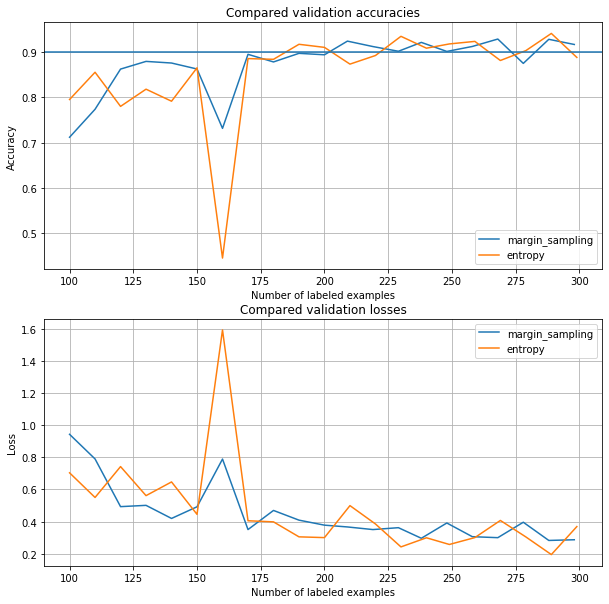

In [74]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
for (name, perf) in performances:
    ax[0].plot(perf[:,0], perf[:,1], label=name)
ax[0].legend(loc='lower right')
ax[0].grid(True)
ax[0].set_title("Compared validation accuracies")
ax[0].set_xlabel("Number of labeled examples")
ax[0].axhline(y=0.9)
ax[0].set_ylabel("Accuracy")

ax[1].set_title("Compared validation losses")
ax[1].set_xlabel("Number of labeled examples")
ax[1].set_ylabel("Loss")
for (name, perf) in performances:
    ax[1].plot(perf[:,0], perf[:,2], label=name)
ax[1].legend(loc='upper right')
ax[1].grid(True)
fig.savefig('ComplexModel.png')

With a more complex network we breach 92% accuracy on the validation within only 210 training samples with margin sampling. Likewise we breach 91% accuracy within 190 training samples using entropy sampling. The best accuracy of 94% is attained with entropy sampling with 290 training samples.

Given the easy nature of the problem ( one channel MNIST) and the relative complexity of the model we are probably beyond overfitting in the risk curves. A simpler model may yield worst result unless we simplify it by a wide margin.

## Committee Selection

At each active run we train N models on the same training set. We select the samples that have the highest summed variance over the N models.

$$ argmax_i[ min_c Var(\hat{(y_i^c)}_{model_0},..,\hat{(y_i^c)}_{model_N})] $$

In [77]:
def active_training_committee(strategy, n_model=5, dataset=None, initial_labeling=20,added_labeling=25):
    if dataset is None:
        dataset = unlabeled_dataset()
        call_expert(dataset, torch.randint(0, len(dataset), (initial_labeling,)))
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                model.zero_grad()
                data = data.reshape(data.shape[0],1,28,28)
                prediction = model(data)   
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                data = data.reshape(data.shape[0],1,28,28)
                prediction = model(data)
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3) 
    
    N_neurons = 20
    output_dim = 10
    N_fc_layers = 2
    N_filters = 3
    kernel_size = 10
    stride = 2    
    
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)
        
        models = {}
        for n_mod in range(n_model):
            # create a new model to train on this dataset
            if i%5==0:
                N_neurons +=5
            #if i%10==0:
            #    N_filters += 1
            input_dim = ((28-kernel_size)/stride+1)*((28-kernel_size)/stride+1)*N_filters
            dims = np.concatenate(([input_dim],[N_neurons]*(N_fc_layers-1),[output_dim]))
            dims = dims.astype('int')
            arch = [nn.Sequential(nn.Conv2d(1,N_filters,kernel_size,stride)),nn.Sequential(nn.Flatten())]
            arch += [nn.Sequential(nn.Linear(input_dim,output_dim)) if output_dim!=10 else nn.Sequential(nn.Linear(input_dim,output_dim)) for input_dim,output_dim in zip(dims[:-1],dims[1:])]
            model = nn.Sequential(*arch)

            # OPTIMIZER
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            train_model(model, optimizer, loader, 50)
            (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
            
            models[n_mod] = model

            # Will be computed with the last model created, does not matter 
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        print("With {} examples, valid perf is: {} -- {}%".format(len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = strategy(models, dataset,added_labeling)
            call_expert(dataset, to_label)
    
    return performances


In [78]:
num_active_runs = 100
num_iter = 100
batch_size = 150

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

# a list of strategies you want to compare
local_strategies = [committee_selection]
# number of examples to label randomly at the start
initial_labeling = 50
added_labeling = 5
performances = []
for strat in local_strategies:
    print("Training with strategy: {}".format(strat.__name__))
    perf = active_training_committee(strat, initial_labeling=initial_labeling,added_labeling=added_labeling)
    performances.append((strat.__name__, perf))
print("done")

Training with strategy: committee_selection
With 50 examples, valid perf is: 1.3377963173389436 -- 65.22000122070312%
With 55 examples, valid perf is: 1.3560904479026794 -- 61.97999572753906%
With 60 examples, valid perf is: 1.2855384302139283 -- 62.900001525878906%
With 65 examples, valid perf is: 1.0919700479507446 -- 67.23999786376953%
With 70 examples, valid perf is: 1.0507364642620087 -- 67.27999877929688%
With 73 examples, valid perf is: 1.4600165688991547 -- 61.18000030517578%
With 78 examples, valid perf is: 1.1834968453645707 -- 67.27999877929688%
With 82 examples, valid perf is: 1.117091784477234 -- 70.26000213623047%
With 86 examples, valid perf is: 1.098750240802765 -- 69.44000244140625%
With 91 examples, valid perf is: 1.0077456432580947 -- 70.52000427246094%
With 96 examples, valid perf is: 1.0463353681564331 -- 71.45999908447266%
With 101 examples, valid perf is: 1.1327993136644363 -- 68.4000015258789%
With 101 examples, valid perf is: 1.0964713501930237 -- 71.7799987792

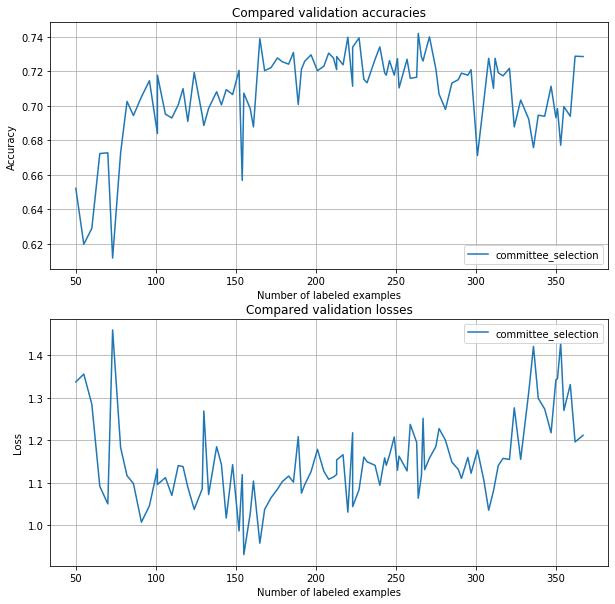

In [82]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
for (name, perf) in performances:
    ax[0].plot(perf[:,0], perf[:,1], label=name)
ax[0].legend(loc='lower right')
ax[0].grid(True)
ax[0].set_title("Compared validation accuracies")
ax[0].set_xlabel("Number of labeled examples")
ax[0].set_ylabel("Accuracy")

ax[1].set_title("Compared validation losses")
ax[1].set_xlabel("Number of labeled examples")
ax[1].set_ylabel("Loss")
for (name, perf) in performances:
    ax[1].plot(perf[:,0], perf[:,2], label=name)
ax[1].legend(loc='upper right')
ax[1].grid(True)

fig.savefig('Committee.png')

Committee selection using a basic architectures performs below the other methods. The outcome may be different if we use a more complex architecture. 

Overall the best performing methods are margin sampling and entropy depending on the architecture of the model. We reach 93% accuracy on the validation set with roughly 200 samples for both those methods. Although we expect the entropy to perform better under the optimal set of parameters since it uses more information regarding the decision making.

The provided code only implement the "random" strategy, which chooses examples at random to label them. Your task is to compare it to other, more guided strategies. For example:

- a strategy that would label in priority the examples for which the classifier is the most uncertain, as measured by the entropy of its output
- a strategy that would label in priority the examples that appear to be near the frontier between the classes: examples for which the highest and second-highest prediction values of the classifier are close to each other.

You can also try to use other relevant decision criterion for choosing which examples to label, and implement them as new strategies. It is also possible to combine strategies together, in order to combine the strong points of each of them.

**Some advice:**

Keep in mind that your goal is to reach the best possible validation accuracy with as little labelled training examples as possible. As such, don't forget to try and change the number of initial examples for labelling, as well as the number of examples your strategy will request for labelling at each round.

Also keep in mind that you network will be trained on possibly very small datasets (think of only a few hundred of examples), while the validation set contains 5000 examples. Be careful of the risks of over-fitting, adjust your network structure and the training time (`num_iter`) appropriately.

As a baseline, you should be able to reach at least 90% of validation accuracy with less than 500 labelled examples.

**When you are done, you're asked to upload this notebook with your model, the different strategies your compared with the graphs generated by the previous code. Your strategies functions should be commented to explain what each strategy does, and which one is your best strategy.**